## Human Data Analytics Final Project
# Predicting lung diseases from X-ray images
## Ngoc Diem Le - 2009466

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Library

In [74]:
# Basic libraries
import os
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
from itertools import cycle
import time

# Image
from PIL import Image

# tensorflow
import tensorflow 
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization, GlobalAveragePooling2D
from mlxtend.plotting import plot_confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras import regularizers

# sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_fscore_support as score

# Operator
from operator import itemgetter

# Visualization
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

# DenseNet architecture 
from keras.applications.densenet import DenseNet121

# VGG16
from keras.applications.vgg16 import VGG16

# VGG19
from keras.applications.vgg19 import VGG19

# Dataset loading

In [5]:
# Images's path
path = '/content/drive/MyDrive/UNIPD/Data/HDA/covid19-pneumonia-normal-chest-xraypa-dataset/COVID19_Pneumonia_Normal_Chest_Xray_PA_Dataset/'

In [6]:
normal_dir = path + 'normal/'
covid_dir = path + 'covid/'
pneumonia_dir = path + 'pneumonia/'

In [7]:
list_data = {}
valid_images = [".jpg", ".jpeg", ".png"]

for idx, dir in enumerate([normal_dir, covid_dir, pneumonia_dir]):
  for f in os.listdir(dir):
    ext = os.path.splitext(f)[1]
    if ext.lower() not in valid_images:
        continue
    list_data[os.path.join(dir,f)] = idx

In [8]:
# Loading data
data = pd.DataFrame(list_data.items(), columns=['directory', 'class'])
data

,directory,class
0,/content/drive/MyDrive/UNIPD/Data/HDA/covid19-...,0
1,/content/drive/MyDrive/UNIPD/Data/HDA/covid19-...,0
2,/content/drive/MyDrive/UNIPD/Data/HDA/covid19-...,0
3,/content/drive/MyDrive/UNIPD/Data/HDA/covid19-...,0
4,/content/drive/MyDrive/UNIPD/Data/HDA/covid19-...,0
...,...,...
4570,/content/drive/MyDrive/UNIPD/Data/HDA/covid19-...,2
4571,/content/drive/MyDrive/UNIPD/Data/HDA/covid19-...,2
4572,/content/drive/MyDrive/UNIPD/Data/HDA/covid19-...,2
4573,/content/drive/MyDrive/UNIPD/Data/HDA/covid19-...,2


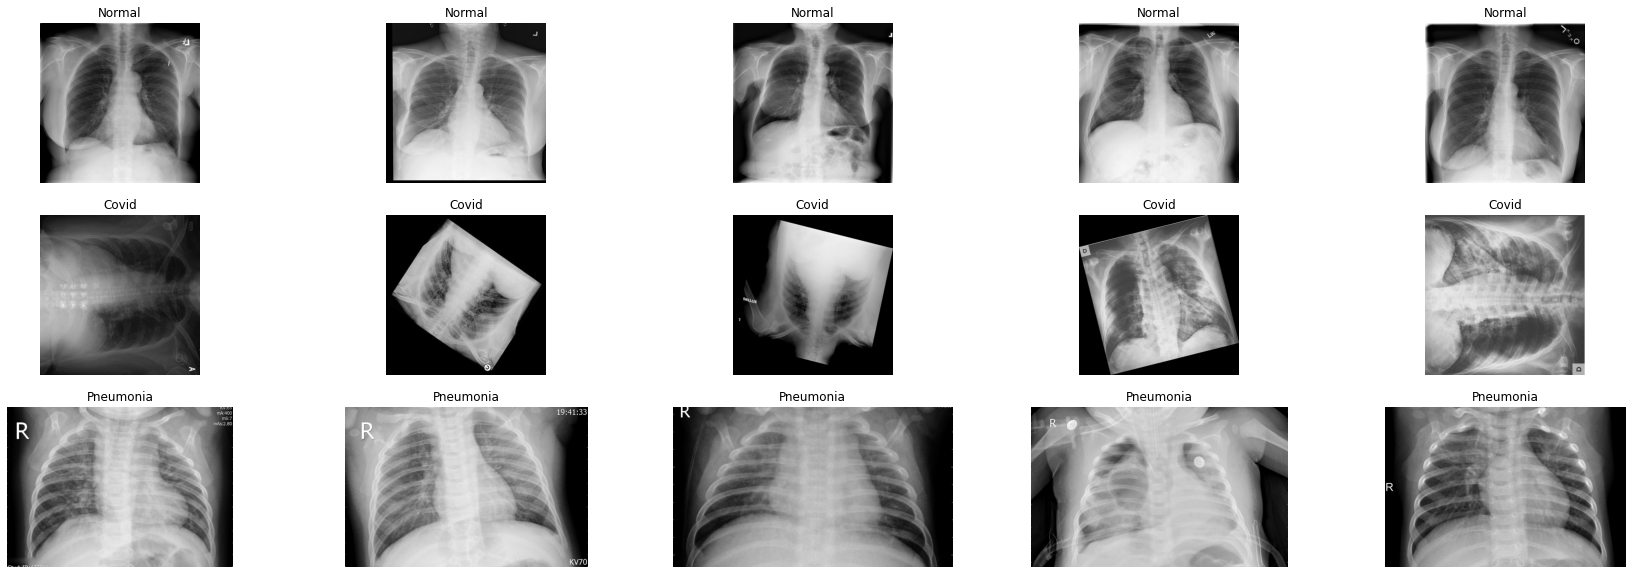

In [9]:
# Visualize X-ray images
normal = os.listdir(path + 'normal')
covid = os.listdir(path + 'covid')
pneumonia = os.listdir(path + 'pneumonia')

fig, ax = plt.subplots(3, 5, figsize=(30,10))

for i in range(15):
  if i < 5:
    img = plt.imread(os.path.join(path + 'normal', normal[i]))
    ax[i//5, i%5].set_title("Normal")
  elif i >= 5 and i < 10:
    img = plt.imread(os.path.join(path + 'covid', covid[i]))
    ax[i//5, i%5].set_title("Covid")
  else:
    img = plt.imread(os.path.join(path + 'pneumonia', pneumonia[i]))
    ax[i//5, i%5].set_title("Pneumonia")
  ax[i//5, i%5].axis('off')
  ax[i//5, i%5].set_aspect('auto')
  ax[i//5, i%5].imshow(img, cmap='gray')
plt.show()

0    1525
1    1525
2    1525
Name: class, dtype: int64


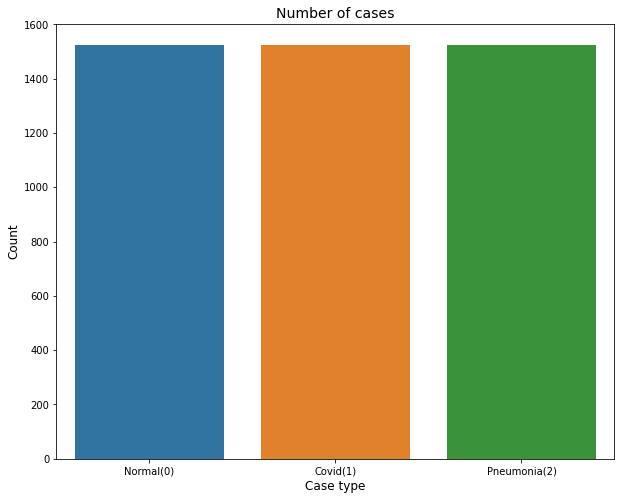

In [10]:
# Get the counts for each class
cases_count = data['class'].value_counts()
print(cases_count)

# Plot the results 
plt.figure(figsize=(10,8))
sns.barplot(x=cases_count.index, y= cases_count.values)
plt.title('Number of cases', fontsize=14)
plt.xlabel('Case type', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(range(len(cases_count.index)), ['Normal(0)', 'Covid(1)', 'Pneumonia(2)'])
plt.show()

In [11]:
# Initial set up
n_epochs = 20
batch_size = 64
n_classes = 3
input_shape = (224, 224, 3)

# Preprocessing

In [12]:
def parse_image(list_filenames):
  list_array = []
  for file in list_filenames:
    img = cv2.imread(file) 
    list_array.append(cv2.resize(img, (224,224))/255)
  return np.array(list_array)

In [13]:
def convert_to_one_hot(Y, number_of_classes):
  Y = np.eye(number_of_classes)[Y.reshape(-1)]
  return Y

In [14]:
X_orig = data['directory'].to_numpy()
y_orig = data['class'].to_numpy()
labels = ['Normal', 'Covid', 'Pneumonia']

In [15]:
X_train_orig, X_valid_orig, y_train, y_valid = train_test_split(X_orig, y_orig, test_size=0.1, stratify = y_orig, random_state=0)
X_train_orig, X_test_orig, y_train, y_test = train_test_split(X_train_orig, y_train, test_size=0.1, stratify = y_train, random_state=0)

In [16]:
uniques_train, counts_train = np.unique(y_train, return_counts=True)
percentages_train = dict(zip(uniques_train, np.round(counts_train * 100 / len(y_train), 2)))
percentages_train

{0: 33.33, 1: 33.33, 2: 33.33}

In [17]:
uniques_valid, counts_valid = np.unique(y_valid, return_counts=True)
percentages_valid = dict(zip(uniques_valid, np.round(counts_valid * 100 / len(y_valid), 2)))
percentages_valid

{0: 33.41, 1: 33.41, 2: 33.19}

In [18]:
uniques_test, counts_test = np.unique(y_test, return_counts=True)
percentages_test = dict(zip(uniques_test, np.round(counts_test * 100 / len(y_test), 2)))
percentages_test

{0: 33.25, 1: 33.25, 2: 33.5}

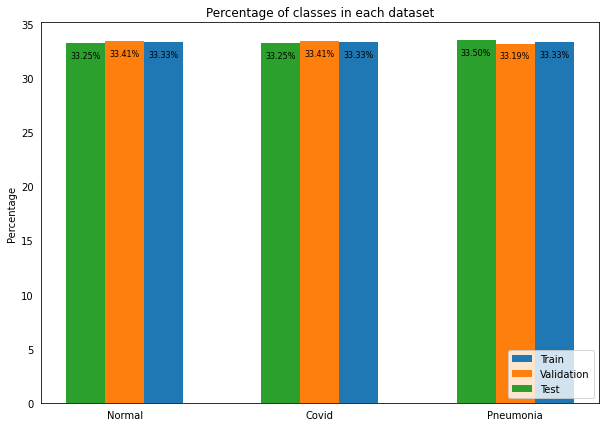

In [19]:
from matplotlib.widgets import PolygonSelector
fig, ax =  plt.subplots(figsize = (10, 7))

X_axis = np.arange(len(labels))

ax1 = ax.bar(X_axis + 0.2, percentages_train.values(), width = 0.2, label = "Train")
ax2 = ax.bar(X_axis, percentages_valid.values(), width = 0.2, label = "Validation")
ax3 = ax.bar(X_axis - 0.2, percentages_test.values(), width = 0.2, label = "Test")

ax.xaxis.set_ticks_position('none')
ax.yaxis.set_ticks_position('none')
ax.set_title('Percentage of classes in each dataset')
ax.set_ylabel('Percentage')
ax.set_xticks(X_axis)
ax.set_xticklabels(labels)
ax.legend(loc='lower right')

def auto_annot(g):
  for p in g.patches:
      g.annotate(format((p.get_height()), '.2f')+"%",
                   (p.get_x() + p.get_width() / 2., p.get_height()),
                   ha='center', va='center',
                   size=8,
                   xytext=(0, -12),
                   textcoords='offset points')


auto_annot(ax)

    
plt.show()

In [20]:
X_train = parse_image(X_train_orig)
X_valid = parse_image(X_valid_orig)
X_test = parse_image(X_test_orig)

In [21]:
print("X_train shape",X_train.shape)
print("X_validation shape",X_valid.shape)
print("X_test shape",X_test.shape)

X_train shape (3705, 224, 224, 3)
X_validation shape (458, 224, 224, 3)
X_test shape (412, 224, 224, 3)


In [22]:
y_train_onehot = convert_to_one_hot(y_train, n_classes)
y_test_onehot = convert_to_one_hot(y_test, n_classes)
y_valid_onehot = convert_to_one_hot(y_valid, n_classes)

In [23]:
print("y_train shape:",y_train_onehot.shape)
print("y_validation shape:",y_valid_onehot.shape)
print("y_test shape:",y_test_onehot.shape)

y_train shape: (3705, 3)
y_validation shape: (458, 3)
y_test shape: (412, 3)


# Models building

In [24]:
# Models' path
path_models = '/content/drive/MyDrive/UNIPD/Data/HDA/models/'

In [25]:
# For comparison part
list_models_name = []
list_n_params = []
list_accuracy = []
list_avg_time = []
list_epochs = []

In [26]:
def learning_curves(number_of_epochs, history, annot_pos):
  # Figure Size
  fig, ax = plt.subplots(2, figsize = (10,7), sharex=True)

  # Loss curves
  ## Training set
  ax[0].plot(np.arange(0, number_of_epochs), history.history["loss"], label="train loss")
  ax[0].annotate('%0.3f' % history.history["loss"][-1], xy=(number_of_epochs - 1, history.history["loss"][-1]), 
               xycoords='data', xytext = annot_pos[0], textcoords='offset points', arrowprops=dict(arrowstyle="->", color = 'black'))
  
  ## Validation set
  ax[0].plot(np.arange(0, number_of_epochs), history.history["val_loss"], label="validation loss")
  ax[0].annotate('%0.3f' % history.history["val_loss"][-1], xy=(number_of_epochs - 1, history.history["val_loss"][-1]), 
               xycoords='data', xytext = annot_pos[1], textcoords='offset points', arrowprops=dict(arrowstyle="->", color = 'black'))
  
  ## Title
  ax[0].set_title('Loss', fontsize = 10)
  
  ## Legend
  ax[0].legend(bbox_to_anchor=(1.0, 1.0), loc='upper left')

  # Accuracy curve
  ## Training set 
  ax[1].plot(np.arange(0, number_of_epochs), history.history["accuracy"], label="train accuracy")
  ax[1].annotate('%0.3f' % history.history["accuracy"][-1], xy=(number_of_epochs - 1, history.history["accuracy"][-1]), 
               xycoords='data', xytext = annot_pos[2], textcoords='offset points', arrowprops=dict(arrowstyle="->", color = 'black'))

  ## Validation set
  ax[1].plot(np.arange(0, number_of_epochs), history.history["val_accuracy"], label="validation accuracy")
  ax[1].annotate('%0.3f' % history.history["val_accuracy"][-1], xy=(number_of_epochs - 1, history.history["val_accuracy"][-1]), 
               xycoords='data', xytext = annot_pos[3], textcoords='offset points', arrowprops=dict(arrowstyle="->", color = 'black'))

  ## Title
  ax[1].set_title('Accuracy', fontsize = 10)

  ## Legend
  ax[1].legend(bbox_to_anchor=(1.0, 1.0), loc='upper left')
    
  # X label
  for a in ax.flat:
      a.set(xlabel='Number of epochs')

  # Hide X labels and tick labels for top plots and y ticks
  for a in ax.flat:
      a.label_outer()

  # Graph's title
  fig.suptitle("Training/ Validation Loss and Accuracy", fontsize = 17)

  plt.show()

## CNN

In [27]:
list_models_name.append('CNN')

In [28]:
# Define CNN model
model_cnn = Sequential()

model_cnn.add(Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu', input_shape=input_shape))
model_cnn.add(Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu'))
model_cnn.add(MaxPooling2D(pool_size=(3,3)))

model_cnn.add(Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu'))
model_cnn.add(Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu'))
model_cnn.add(MaxPooling2D(pool_size=(3,3)))

model_cnn.add(Conv2D(filters=128, kernel_size=(3,3), padding='same', activation='relu'))
model_cnn.add(Conv2D(filters=128, kernel_size=(3,3), padding='same', activation='relu'))
model_cnn.add(MaxPooling2D(pool_size=(3,3)))

model_cnn.add(Flatten())

model_cnn.add(Dense(16, activation='relu'))
model_cnn.add(Dense(3, activation='softmax'))

In [29]:
model_cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 224, 224, 32)      9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 32)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 74, 74, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 74, 74, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 24, 24, 64)       0         
 2D)                                                    

In [30]:
number_params_cnn = model_cnn.count_params()
list_n_params.append(number_params_cnn)
print('Number of parameters in model: {}'.format(number_params_cnn))

Number of parameters in model: 418147


In [31]:
# Define the optimizer
optimizer = Adam(learning_rate=0.001)

# Define early stopping
early_stopping = EarlyStopping(monitor='val_loss', 
    patience=10, 
    min_delta=0)

In [32]:
# Compilte the model
model_cnn.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics = ['accuracy'])

In [33]:
# Data augmentation
datagen = ImageDataGenerator(rotation_range=20,
                             zoom_range=0.2)
                         
datagen.fit(X_train)

In [34]:
# Fit the model
start = time.time()
history_cnn = model_cnn.fit_generator(datagen.flow(X_train, y_train_onehot, batch_size=batch_size),
                                  epochs = n_epochs, 
                                  validation_data = (X_valid, y_valid_onehot),
                                  steps_per_epoch=X_train.shape[0] // batch_size,
                                  callbacks = [early_stopping])

end = time.time()
# Counting training time
print('Time complexity analysis')
print("Training time: {:.2f}s".format(end-start))
number_of_epochs_in_es = len(history_cnn.history['loss'])
avg_time = (end-start)/number_of_epochs_in_es
list_avg_time.append(avg_time)
print("Average time per epoch: {:.2f}s".format(avg_time))

model_cnn.save(path_models + 'CNN')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  import sys


Epoch 1/20
57/57 [==============================] - 46s 607ms/step - loss: 0.8337 - accuracy: 0.6155 - val_loss: 0.5956 - val_accuracy: 0.8035
Epoch 2/20
57/57 [==============================] - 34s 600ms/step - loss: 0.6469 - accuracy: 0.7462 - val_loss: 0.4867 - val_accuracy: 0.8428
Epoch 3/20
57/57 [==============================] - 34s 603ms/step - loss: 0.5307 - accuracy: 0.7896 - val_loss: 0.5393 - val_accuracy: 0.7860
Epoch 4/20
57/57 [==============================] - 34s 600ms/step - loss: 0.4879 - accuracy: 0.8275 - val_loss: 0.3561 - val_accuracy: 0.8712
Epoch 5/20
57/57 [==============================] - 34s 599ms/step - loss: 0.4316 - accuracy: 0.8470 - val_loss: 0.3254 - val_accuracy: 0.8996
Epoch 6/20
57/57 [==============================] - 34s 603ms/step - loss: 0.3747 - accuracy: 0.8775 - val_loss: 0.2878 - val_accuracy: 0.9148
Epoch 7/20
57/57 [==============================] - 34s 599ms/step - loss: 0.3409 - accuracy: 0.8805 - val_loss: 0.2616 - val_accuracy: 0.9127

In [35]:
print('Number of epochs: ', n_epochs)
print('Number of actual epochs ran: ', number_of_epochs_in_es)
list_epochs.append(number_of_epochs_in_es)

Number of epochs:  20
Number of actual epochs ran:  20


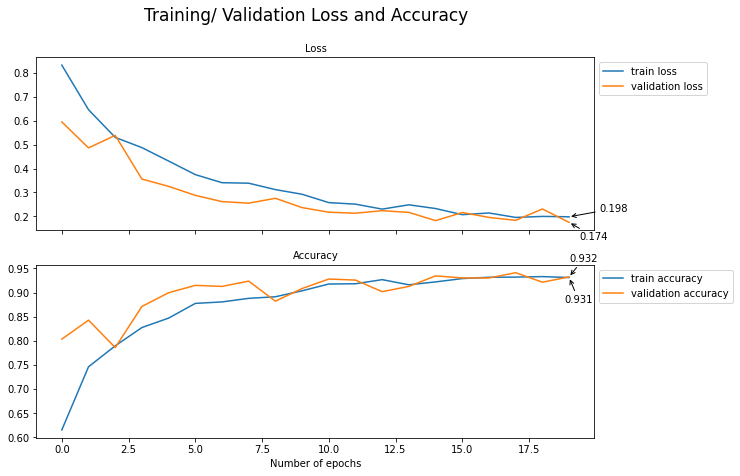

In [36]:
learning_curves(number_of_epochs_in_es, history_cnn, [(30,5), (10,-17), (-5,-25), (0,15)])

### Evaluation

In [37]:
# Evaluate the model
test_loss, test_score = model_cnn.evaluate(X_test, y_test_onehot)
list_accuracy.append(np.round(test_score*100,2))
print("Loss on test set: {:.2f}".format(test_loss))
print("Accuracy on test set: {:.2f}%".format(test_score*100))

13/13 [==============================] - 0s 29ms/step - loss: 0.2117 - accuracy: 0.9272
Loss on test set: 0.21
Accuracy on test set: 92.72%


In [38]:
# Get predictions
preds = model_cnn.predict(X_test)
preds = np.argmax(preds, axis=-1)

# Original labels
orig_test_labels = np.argmax(y_test_onehot, axis=-1)

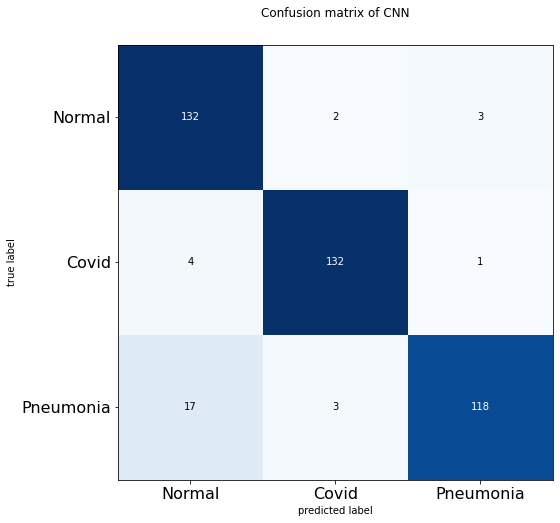

In [39]:
# Get the confusion matrix
cm  = confusion_matrix(orig_test_labels, preds)
plot_confusion_matrix(cm,figsize=(12,8), hide_ticks=True, cmap=plt.cm.Blues)
plt.xticks(range(3), ['Normal', 'Covid', 'Pneumonia'], fontsize=16)
plt.yticks(range(3), ['Normal', 'Covid', 'Pneumonia'], fontsize=16)
plt.title('Confusion matrix of CNN')
plt.show()

In [41]:
print(classification_report(orig_test_labels, preds, target_names = labels))

              precision    recall  f1-score   support

      Normal       0.86      0.96      0.91       137
       Covid       0.96      0.96      0.96       137
   Pneumonia       0.97      0.86      0.91       138

    accuracy                           0.93       412
   macro avg       0.93      0.93      0.93       412
weighted avg       0.93      0.93      0.93       412



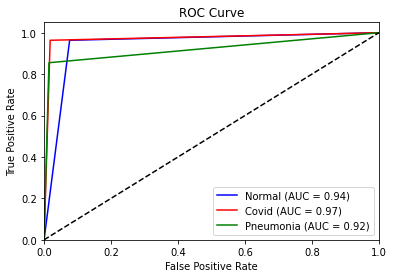

In [42]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_onehot[:, i], convert_to_one_hot(preds, n_classes)[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

colors = cycle(['blue', 'red', 'green'])

for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=1.5,
             label='{0} (AUC = {1:0.2f})'
             ''.format(labels[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

## DenseNet

In [43]:
list_models_name.append('DenseNet')

In [44]:
weight_for_0 = len(normal) / (len(normal) + len(covid) + len(pneumonia))
weight_for_1 = len(covid) / (len(normal) + len(covid) + len(pneumonia))
weight_for_2 = len(pneumonia) / (len(normal) + len(covid) + len(pneumonia))

class_weight = {0: weight_for_0, 1: weight_for_1, 2: weight_for_2}

densenet_basemodel = DenseNet121(input_shape=input_shape, include_top=False, weights='imagenet')

29097984/29084464 [==============================] - 1s 0us/step


In [45]:
layers = densenet_basemodel.layers
print("The model has {} layers".format(len(layers)))

The model has 427 layers


In [46]:
for layer in densenet_basemodel.layers:
    layer.trainable = False

x = densenet_basemodel.output

x = GlobalAveragePooling2D()(x)
x = Dense(1024,activation='relu')(x) 
x = Dense(512,activation='relu')(x) 

predictions = Dense(n_classes, activation='softmax')(x)

model_densenet = Model(inputs=densenet_basemodel.input, outputs=predictions)

In [47]:
number_params_densenet = model_densenet.count_params()
list_n_params.append(number_params_densenet)
print('Number of parameters in model: {}'.format(number_params_densenet))

Number of parameters in model: 8613443


In [48]:
model_densenet.compile(loss='categorical_crossentropy', optimizer = Adam(learning_rate=0.0001), metrics=['accuracy'])

In [49]:
#model_densenet.summary()

In [50]:
start = time.time()
densenet = model_densenet.fit_generator(datagen.flow(X_train, y_train_onehot, batch_size=batch_size), 
                     epochs=n_epochs, 
                     validation_data=(X_valid, y_valid_onehot), 
                     class_weight=class_weight,
                     callbacks = [early_stopping])
end = time.time()
# Counting training time
print('Time complexity analysis')
print("Training time: {:.2f}s".format(end-start))
number_of_epochs_in_es = len(densenet.history['loss'])
avg_time = (end-start)/number_of_epochs_in_es
list_avg_time.append(avg_time)
print("Average time per epoch: {:.2f}s".format(avg_time))

#model_densenet.save(path_models + 'DenseNet')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


Epoch 1/20
58/58 [==============================] - 47s 670ms/step - loss: 0.1732 - accuracy: 0.8059 - val_loss: 0.3406 - val_accuracy: 0.9061
Epoch 2/20
58/58 [==============================] - 36s 621ms/step - loss: 0.1161 - accuracy: 0.8856 - val_loss: 0.2799 - val_accuracy: 0.9105
Epoch 3/20
58/58 [==============================] - 36s 617ms/step - loss: 0.0996 - accuracy: 0.9028 - val_loss: 0.2899 - val_accuracy: 0.9083
Epoch 4/20
58/58 [==============================] - 36s 622ms/step - loss: 0.0916 - accuracy: 0.9082 - val_loss: 0.2501 - val_accuracy: 0.9105
Epoch 5/20
58/58 [==============================] - 36s 621ms/step - loss: 0.0890 - accuracy: 0.9066 - val_loss: 0.2497 - val_accuracy: 0.9170
Epoch 6/20
58/58 [==============================] - 36s 620ms/step - loss: 0.0812 - accuracy: 0.9158 - val_loss: 0.2559 - val_accuracy: 0.9258
Epoch 7/20
58/58 [==============================] - 36s 621ms/step - loss: 0.0810 - accuracy: 0.9158 - val_loss: 0.2237 - val_accuracy: 0.9323

In [51]:
print('Number of epochs: ', n_epochs)
print('Number of actual epochs ran: ', number_of_epochs_in_es)
list_epochs.append(number_of_epochs_in_es)

Number of epochs:  20
Number of actual epochs ran:  20


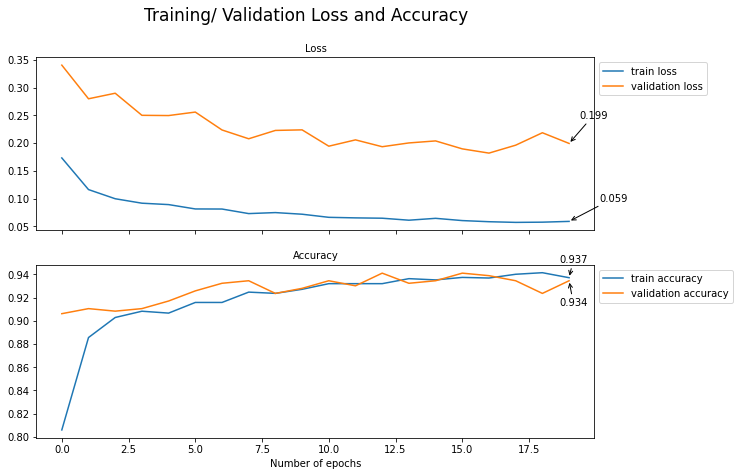

In [52]:
learning_curves(number_of_epochs_in_es, densenet, [(30,20), (10,25), (-10,15), (-10,-25)])

### Evaluation

In [53]:
# Evaluate the model
test_loss, test_score = model_densenet.evaluate(X_test, y_test_onehot)
list_accuracy.append(np.round(test_score*100,2))
print("Loss on test set: {:.2f}".format(test_loss))
print("Accuracy on test set: {:.2f}%".format(test_score*100))

13/13 [==============================] - 1s 96ms/step - loss: 0.2067 - accuracy: 0.9345
Loss on test set: 0.21
Accuracy on test set: 93.45%


In [54]:
# Get predictions
preds = model_densenet.predict(X_test)
preds = np.argmax(preds, axis=-1)

# Original labels
orig_test_labels = np.argmax(y_test_onehot, axis=-1)

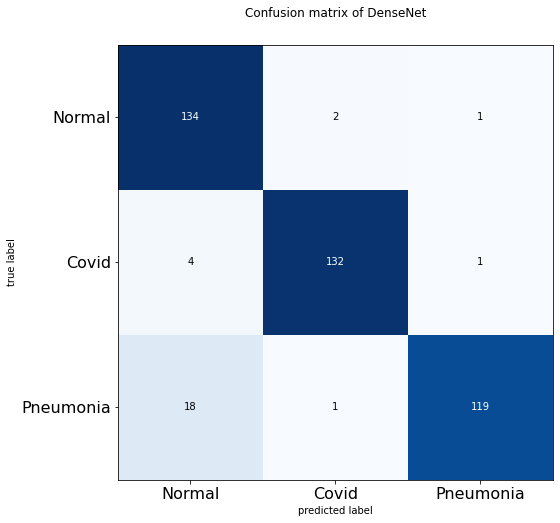

In [55]:
# Get the confusion matrix
cm  = confusion_matrix(orig_test_labels, preds)
plot_confusion_matrix(cm,figsize=(12,8), hide_ticks=True, cmap=plt.cm.Blues)
plt.xticks(range(3), ['Normal', 'Covid', 'Pneumonia'], fontsize=16)
plt.yticks(range(3), ['Normal', 'Covid', 'Pneumonia'], fontsize=16)
plt.title('Confusion matrix of DenseNet')
plt.show()

In [57]:
print(classification_report(orig_test_labels, preds, target_names = labels))

              precision    recall  f1-score   support

      Normal       0.86      0.98      0.91       137
       Covid       0.98      0.96      0.97       137
   Pneumonia       0.98      0.86      0.92       138

    accuracy                           0.93       412
   macro avg       0.94      0.93      0.93       412
weighted avg       0.94      0.93      0.93       412



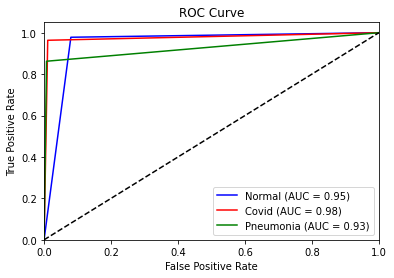

In [58]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_onehot[:, i], convert_to_one_hot(preds, n_classes)[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

colors = cycle(['blue', 'red', 'green'])

for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=1.5,
             label='{0} (AUC = {1:0.2f})'
             ''.format(labels[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

## VGG16

In [59]:
list_models_name.append('VGG16')

In [60]:
baseModel = VGG16(input_shape=input_shape, weights='imagenet', include_top=False)

for layer in baseModel.layers:
    layer.trainable = False

x = baseModel.output
x = GlobalAveragePooling2D()(x)
x = Flatten()(x)
x = Dense(512,activation='relu')(x)
x = Dropout(0.2)(x)

predictions = Dense(3, activation='softmax')(x)

model_vgg16 = Model(inputs=baseModel.input, outputs=predictions)

58900480/58889256 [==============================] - 0s 0us/step


In [61]:
number_params_vgg16 = model_vgg16.count_params()
list_n_params.append(number_params_vgg16)
print('Number of parameters in model: {}'.format(number_params_vgg16))

Number of parameters in model: 14978883


In [62]:
model_vgg16.compile(loss='categorical_crossentropy', optimizer = Adam(learning_rate=0.0001), metrics=['accuracy'])

In [63]:
start = time.time()
vgg16 = model_vgg16.fit_generator(datagen.flow(X_train, y_train_onehot, batch_size=batch_size), 
                                  epochs=n_epochs, 
                                  validation_data=(X_valid, y_valid_onehot), 
                                  class_weight=class_weight,
                                  callbacks = [early_stopping])
end = time.time()
# Counting training time
print('Time complexity analysis')
print("Training time: {:.2f}s".format(end-start))
number_of_epochs_in_es = len(vgg16.history['loss'])
avg_time = (end-start)/number_of_epochs_in_es
list_avg_time.append(avg_time)
print("Average time per epoch: {:.2f}s".format(avg_time))

model_vgg16.save(path_models + 'VGG16')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


Epoch 1/20
58/58 [==============================] - 39s 643ms/step - loss: 0.3445 - accuracy: 0.4802 - val_loss: 0.8890 - val_accuracy: 0.8210
Epoch 2/20
58/58 [==============================] - 37s 634ms/step - loss: 0.2924 - accuracy: 0.6802 - val_loss: 0.7502 - val_accuracy: 0.8057
Epoch 3/20
58/58 [==============================] - 37s 636ms/step - loss: 0.2566 - accuracy: 0.7474 - val_loss: 0.6513 - val_accuracy: 0.8231
Epoch 4/20
58/58 [==============================] - 37s 630ms/step - loss: 0.2339 - accuracy: 0.7665 - val_loss: 0.5792 - val_accuracy: 0.8493
Epoch 5/20
58/58 [==============================] - 36s 614ms/step - loss: 0.2126 - accuracy: 0.7957 - val_loss: 0.5303 - val_accuracy: 0.8493
Epoch 6/20
58/58 [==============================] - 36s 619ms/step - loss: 0.1966 - accuracy: 0.8097 - val_loss: 0.4941 - val_accuracy: 0.8537
Epoch 7/20
58/58 [==============================] - 36s 619ms/step - loss: 0.1859 - accuracy: 0.8159 - val_loss: 0.4661 - val_accuracy: 0.8712

In [64]:
print('Number of epochs: ', n_epochs)
print('Number of actual epochs ran: ', number_of_epochs_in_es)
list_epochs.append(number_of_epochs_in_es)

Number of epochs:  20
Number of actual epochs ran:  20


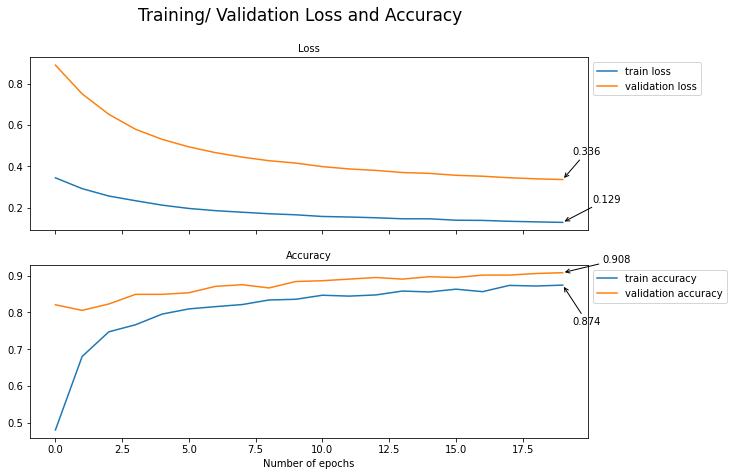

In [65]:
learning_curves(number_of_epochs_in_es, vgg16, [(30,20), (10,25), (10,-40), (40,10)])

### Evaluation

In [66]:
# Evaluate the model
test_loss, test_score = model_vgg16.evaluate(X_test, y_test_onehot)
list_accuracy.append(np.round(test_score*100,2))
print("Loss on test set: {:.2f}".format(test_loss))
print("Accuracy on test set: {:.2f}%".format(test_score*100))

13/13 [==============================] - 2s 131ms/step - loss: 0.3733 - accuracy: 0.8786
Loss on test set: 0.37
Accuracy on test set: 87.86%


In [67]:
# Get predictions
preds = model_vgg16.predict(X_test)
preds = np.argmax(preds, axis=-1)

# Original labels
orig_test_labels = np.argmax(y_test_onehot, axis=-1)

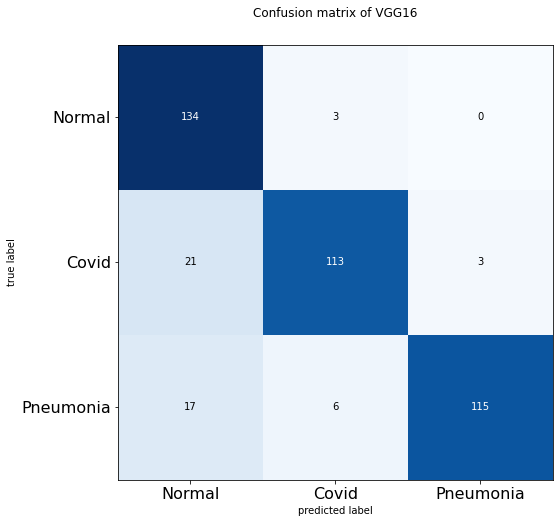

In [68]:
# Get the confusion matrix
cm  = confusion_matrix(orig_test_labels, preds)
plot_confusion_matrix(cm,figsize=(12,8), hide_ticks=True, cmap=plt.cm.Blues)
plt.xticks(range(3), ['Normal', 'Covid', 'Pneumonia'], fontsize=16)
plt.yticks(range(3), ['Normal', 'Covid', 'Pneumonia'], fontsize=16)
plt.title('Confusion matrix of VGG16')
plt.show()

In [70]:
print(classification_report(orig_test_labels, preds, target_names = labels))

              precision    recall  f1-score   support

      Normal       0.78      0.98      0.87       137
       Covid       0.93      0.82      0.87       137
   Pneumonia       0.97      0.83      0.90       138

    accuracy                           0.88       412
   macro avg       0.89      0.88      0.88       412
weighted avg       0.89      0.88      0.88       412



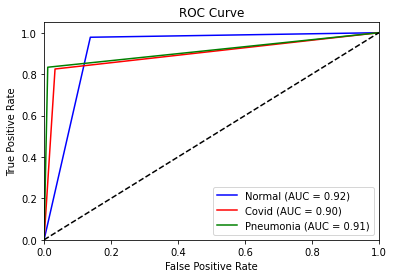

In [71]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_onehot[:, i], convert_to_one_hot(preds, n_classes)[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

colors = cycle(['blue', 'red', 'green'])

for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=1.5,
             label='{0} (AUC = {1:0.2f})'
             ''.format(labels[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

## VGG19

In [72]:
list_models_name.append('VGG19')

In [75]:
baseModel = VGG19(input_shape=input_shape, weights='imagenet', include_top=False)

for layer in baseModel.layers:
    layer.trainable = False

x = baseModel.output
x = GlobalAveragePooling2D()(x)
x = Flatten()(x)
x = Dense(1024,activation='relu')(x) 
x = Dense(512,activation='relu')(x)
x = Dropout(0.2)(x)

predictions = Dense(3, activation='softmax')(x)

model_vgg19 = Model(inputs=baseModel.input, outputs=predictions)

80150528/80134624 [==============================] - 1s 0us/step


In [76]:
number_params_vgg19 = model_vgg19.count_params()
list_n_params.append(number_params_vgg19)
print('Number of parameters in model: {}'.format(number_params_vgg19))

Number of parameters in model: 21076035


In [77]:
model_vgg19.compile(loss='categorical_crossentropy', optimizer = Adam(learning_rate=0.001), metrics=['accuracy'])

In [78]:
start = time.time()
vgg19 = model_vgg19.fit_generator(datagen.flow(X_train, y_train_onehot, batch_size=batch_size), 
                                   epochs=n_epochs, 
                                   validation_data=(X_valid, y_valid_onehot), 
                                   class_weight=class_weight,
                                  callbacks = [early_stopping])
end = time.time()
# Counting training time
print('Time complexity analysis')
print("Training time: {:.2f}s".format(end-start))
number_of_epochs_in_es = len(vgg19.history['loss'])
avg_time = (end-start)/number_of_epochs_in_es
list_avg_time.append(avg_time)
print("Average time per epoch: {:.2f}s".format(avg_time))

model_vgg19.save(path_models + 'VGG19')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


Epoch 1/20
58/58 [==============================] - 38s 643ms/step - loss: 0.2878 - accuracy: 0.6372 - val_loss: 0.5555 - val_accuracy: 0.7707
Epoch 2/20
58/58 [==============================] - 37s 633ms/step - loss: 0.1669 - accuracy: 0.8162 - val_loss: 0.4136 - val_accuracy: 0.8362
Epoch 3/20
58/58 [==============================] - 37s 638ms/step - loss: 0.1414 - accuracy: 0.8502 - val_loss: 0.2987 - val_accuracy: 0.8996
Epoch 4/20
58/58 [==============================] - 37s 634ms/step - loss: 0.1345 - accuracy: 0.8524 - val_loss: 0.3033 - val_accuracy: 0.8996
Epoch 5/20
58/58 [==============================] - 37s 638ms/step - loss: 0.1240 - accuracy: 0.8691 - val_loss: 0.4168 - val_accuracy: 0.8275
Epoch 6/20
58/58 [==============================] - 37s 637ms/step - loss: 0.1177 - accuracy: 0.8764 - val_loss: 0.3137 - val_accuracy: 0.8777
Epoch 7/20
58/58 [==============================] - 37s 635ms/step - loss: 0.1166 - accuracy: 0.8707 - val_loss: 0.3219 - val_accuracy: 0.8755

In [81]:
print('Number of epochs: ', n_epochs)
print('Number of actual epochs ran: ', number_of_epochs_in_es)
list_epochs.append(number_of_epochs_in_es)

Number of epochs:  20
Number of actual epochs ran:  20


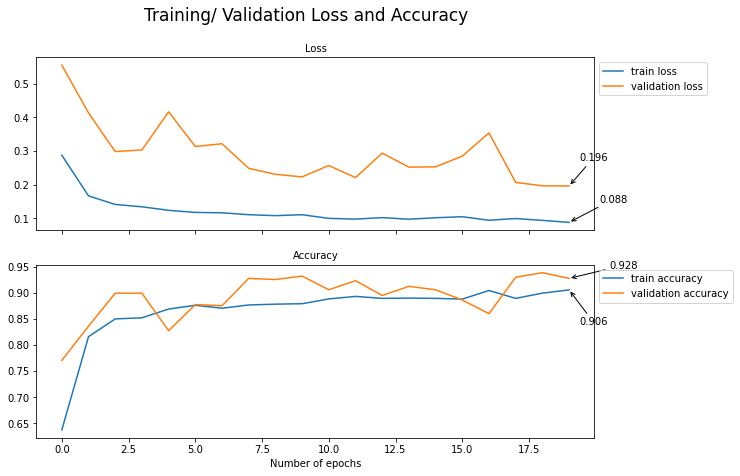

In [82]:
learning_curves(number_of_epochs_in_es, vgg19, [(30,20), (10,25), (10,-35), (40,10)])

### Evaluation

In [83]:
# Evaluate the model
test_loss, test_score = model_vgg19.evaluate(X_test, y_test_onehot)
list_accuracy.append(np.round(test_score*100,2))
print("Loss on test set: {:.2f}".format(test_loss))
print("Accuracy on test set: {:.2f}%".format(test_score*100))

13/13 [==============================] - 1s 94ms/step - loss: 0.2460 - accuracy: 0.9150
Loss on test set: 0.25
Accuracy on test set: 91.50%


In [84]:
# Get predictions
preds = model_vgg19.predict(X_test)
preds = np.argmax(preds, axis=-1)

# Original labels
orig_test_labels = np.argmax(y_test_onehot, axis=-1)

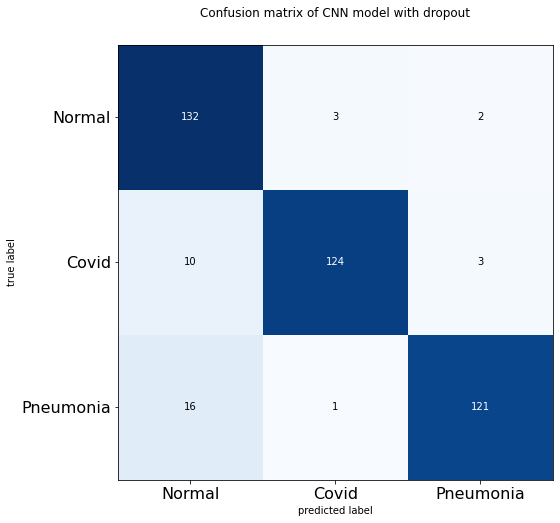

In [85]:
# Get the confusion matrix
cm  = confusion_matrix(orig_test_labels, preds)
plot_confusion_matrix(cm,figsize=(12,8), hide_ticks=True, cmap=plt.cm.Blues)
plt.xticks(range(3), ['Normal', 'Covid', 'Pneumonia'], fontsize=16)
plt.yticks(range(3), ['Normal', 'Covid', 'Pneumonia'], fontsize=16)
plt.title('Confusion matrix of CNN model with dropout')
plt.show()

In [87]:
print(classification_report(orig_test_labels, preds, target_names = labels))

              precision    recall  f1-score   support

      Normal       0.84      0.96      0.89       137
       Covid       0.97      0.91      0.94       137
   Pneumonia       0.96      0.88      0.92       138

    accuracy                           0.92       412
   macro avg       0.92      0.92      0.92       412
weighted avg       0.92      0.92      0.92       412



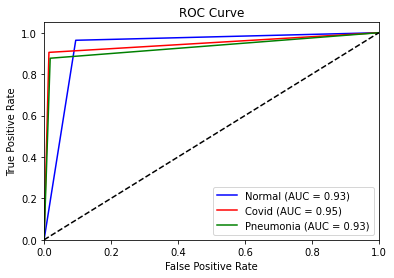

In [88]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_onehot[:, i], convert_to_one_hot(preds, n_classes)[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

colors = cycle(['blue', 'red', 'green'])

for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=1.5,
             label='{0} (AUC = {1:0.2f})'
             ''.format(labels[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

# Performance Comparision 

In [89]:
# Function to creat barplot
def barplot(sorted_list, unit_of_value, ylabel, graph_title):
  # Figure Size
  fig, ax = plt.subplots(figsize =(16, 9))

  # Vertical Bar Plot
  ax.bar(*zip(*sorted_list), color = 'royalblue')

  # Remove axes splines
  for s in ['top', 'bottom', 'left', 'right']:
      ax.spines[s].set_visible(False)
 
  # Remove x, y Ticks
  ax.xaxis.set_ticks_position('none')
  ax.yaxis.set_ticks_position('none')
 
  # Add padding between axes and labels
  ax.xaxis.set_tick_params(pad = 5)
  ax.yaxis.set_tick_params(pad = 10)
 
  # Add x, y gridlines
  ax.grid(b = True, color ='grey',
        linestyle ='-.', linewidth = 0.5,
        alpha = 0.2)
 
  # Add annotation to bars
  for bar in ax.patches:
    ax.annotate('{}{}'.format(np.round(bar.get_height(), 2), unit_of_value),
                   (bar.get_x() + bar.get_width() / 2,
                    bar.get_height()), ha='center', va='center',
                   size=10, xytext=(0, 8),
                   textcoords='offset points')
 
  # Add y label
  ax.set_ylabel(ylabel)

  # Add Plot Title
  ax.set_title(graph_title)
 
  # Show graph
  plt.show()

In [90]:
# Function changing from values in dictionary to percentage
def value_to_percentage(dictionary):
  dict_percentage = {}
  for model, value in dictionary.items():
    fix_var = dictionary['CNN'] # Using CNN as base model
    dict_percentage[model] = np.round((value/fix_var)*100, 2)
  return dict_percentage

## Accuracy

In [91]:
# Combine model's name and accuracy values 
acc_dict = dict(zip(list_models_name, list_accuracy))

# Sorted 
sorted_acc = sorted(acc_dict.items(), key=itemgetter(1), reverse=True)

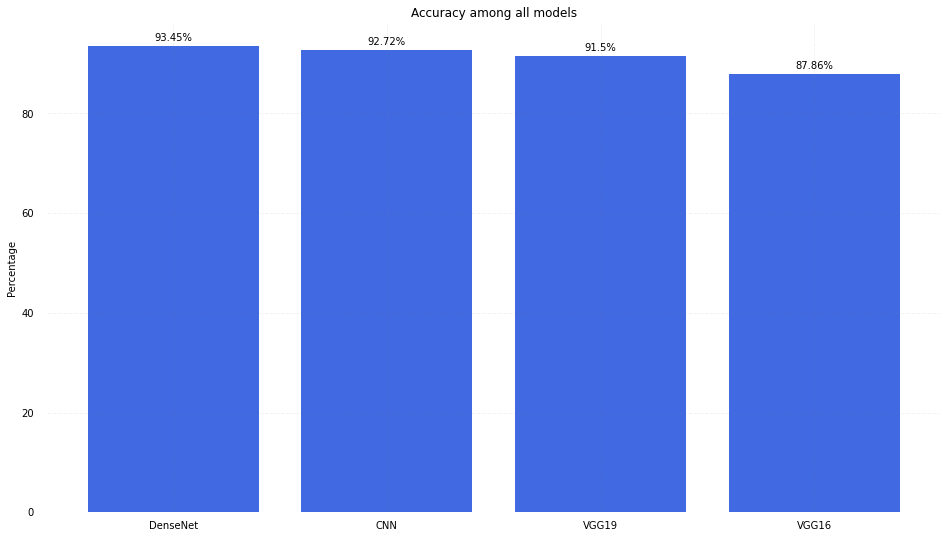

In [92]:
barplot(sorted_acc, '%', 'Percentage', 'Accuracy among all models')

## Number of parameters

In [95]:
# Combine model's name and accuracy values 
n_params_dict = dict(zip(list_models_name, list_n_params))

# Sorted 
sorted_n_params = sorted(n_params_dict.items(), key=itemgetter(1), reverse=True)

In [96]:
max_params = np.max(list_n_params)
percentage_params = [i*100/max_params for i in list_n_params]
percentage_params_dict = dict(zip(list_models_name, percentage_params))
sorted_n_params_percentage = sorted(percentage_params_dict.items(), key=itemgetter(1), reverse=True)

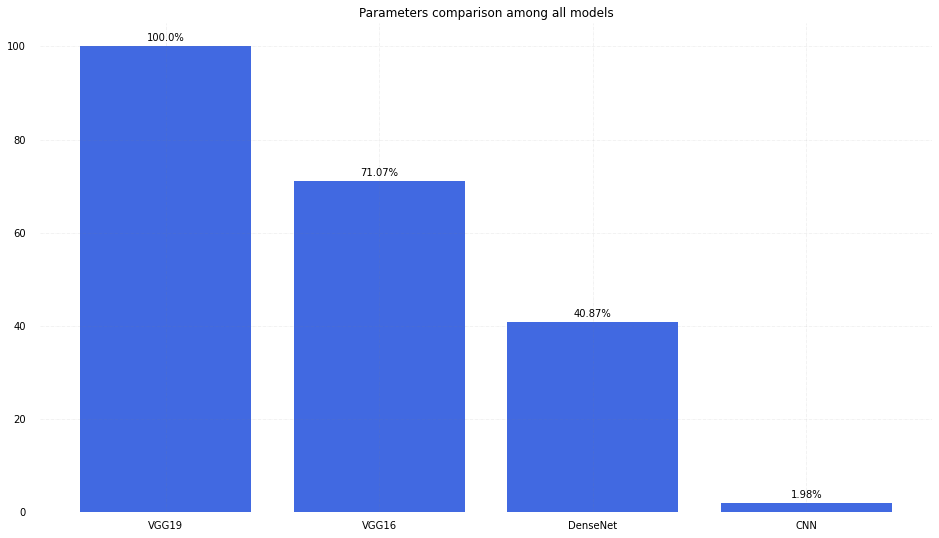

In [97]:
barplot(sorted_n_params_percentage, '%', '', 'Parameters comparison among all models')

## Number of epochs

In [98]:
# Combine model's name and accuracy values 
n_epochs_dict = dict(zip(list_models_name, list_epochs))

# Sorted 
sorted_n_epochs = sorted(n_epochs_dict.items(), key=itemgetter(1), reverse=True)

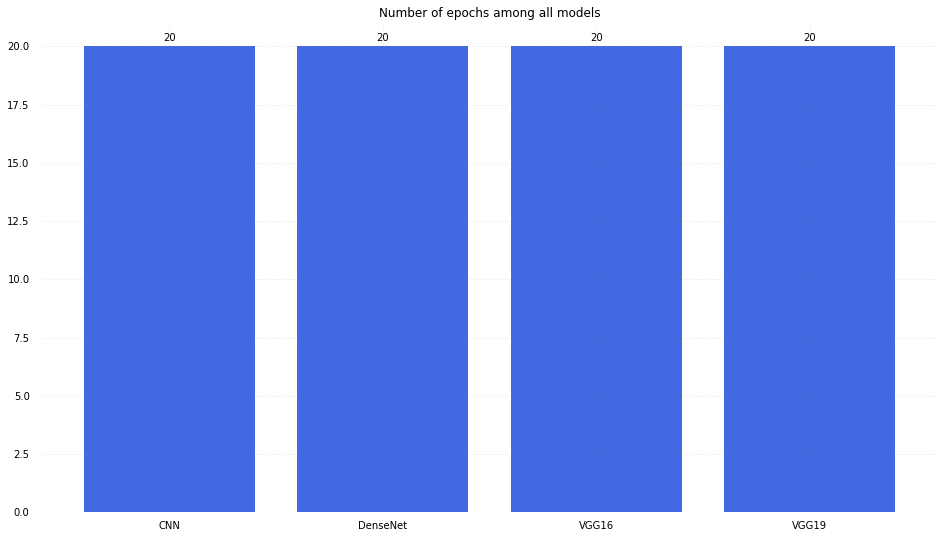

In [99]:
barplot(sorted_n_epochs, '', '', 'Number of epochs among all models')

## Average time per epoch

In [100]:
# Combine model's name and accuracy values 
time_dict = dict(zip(list_models_name, list_avg_time))

# Sorted 
sorted_time = sorted(time_dict.items(), key=itemgetter(1), reverse=False)

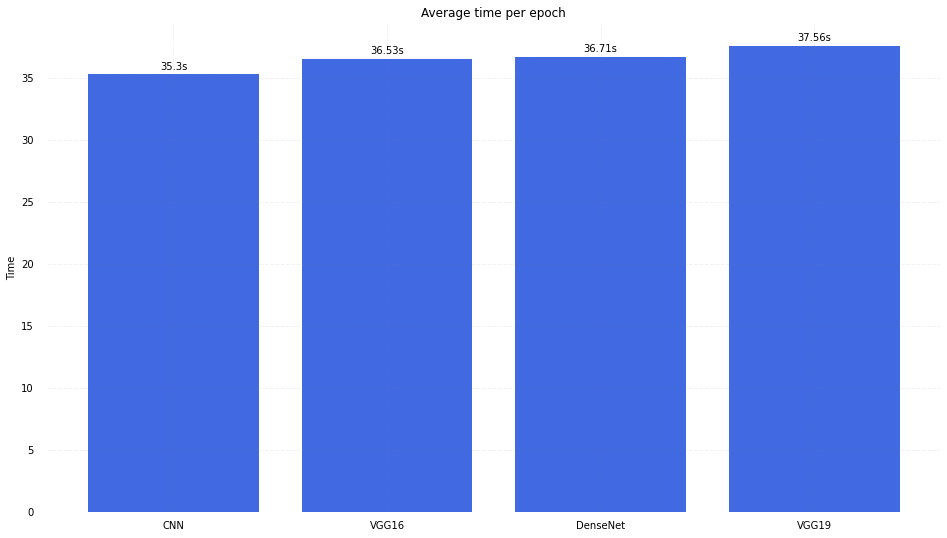

In [101]:
barplot(sorted_time, 's', 'Time', 'Average time per epoch')

## Combination of time and accuracy

In [102]:
# Normalize number of params
number_of_params_normalized = [float(i)/max(list_n_params) for i in list_n_params]

# Combine model's name and accuracy values 
n_params_norm_dict = dict(zip(list_models_name, number_of_params_normalized))

# Sorted
sorted_params_norm = sorted(n_params_norm_dict.items(), key=itemgetter(1), reverse=False)

In [103]:
# Normalize time per epoch
time_normalized = [float(i)/max(list_avg_time) for i in list_avg_time]

# Combine model's name and accuracy values 
time_norm_dict = dict(zip(list_models_name, time_normalized))

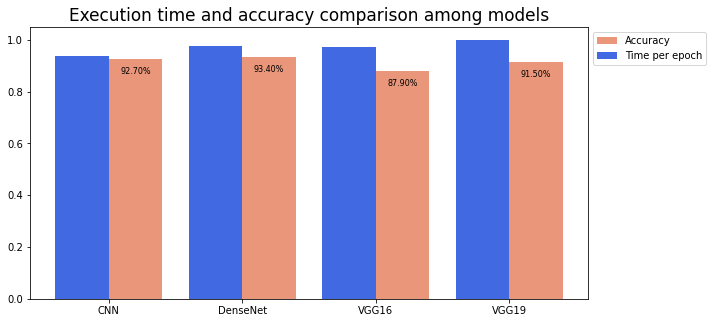

In [110]:
# Number of models
n_models = np.arange(len(list_models_name))

# Figure Size
fig, ax = plt.subplots(figsize =(10, 5))

# Vertical barplot
ax.bar(n_models, acc_dict_norm.values(), width=0.4, color='darksalmon', align='center')
for p in ax.patches:
      ax.annotate(format((p.get_height()*100), '.2f')+"%",
                   (p.get_x() + p.get_width() / 2., p.get_height()),
                   ha='center', va='center',
                   size=8,
                   xytext=(0, -12),
                   textcoords='offset points')
      
ax.bar(n_models - 0.4, time_norm_dict.values(), width=0.4, color='royalblue', align='center')


# Add xticks
ax.set_xticks(np.arange(len(list_models_name)) - 0.2)
ax.set_xticklabels(list_models_name)

# Add title
plt.title("Execution time and accuracy comparison among models", fontsize=17)

# Add legend
plt.legend(bbox_to_anchor=(1.0, 1.0), loc='upper left', labels = ['Accuracy','Time per epoch'])

# Show graph
plt.show()

## Loss

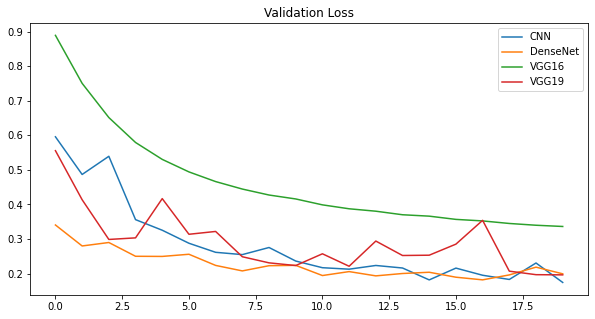

In [106]:
fig, ax = plt.subplots(figsize =(10, 5))

ax.plot(np.arange(0, n_epochs), history_cnn.history["val_loss"])
ax.plot(np.arange(0, n_epochs), densenet.history["val_loss"])
ax.plot(np.arange(0, n_epochs), vgg16.history["val_loss"])
ax.plot(np.arange(0, n_epochs), vgg19.history["val_loss"])
plt.legend(loc='upper right', labels = list_models_name)
plt.title("Validation Loss")
plt.show()